# Import data

In [736]:
import pandas as pd

df = pd.read_csv('winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [737]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [738]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<Axes: >

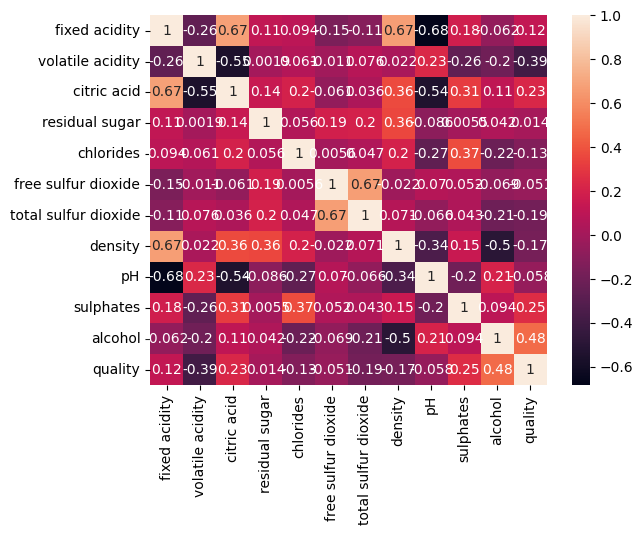

In [739]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='quality', ylabel='count'>

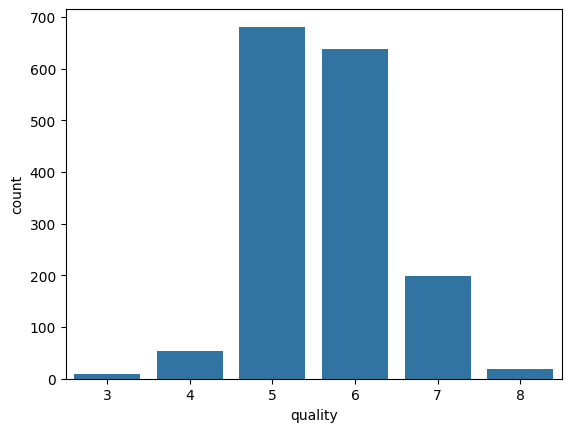

In [740]:
sns.countplot(data=df, x='quality')

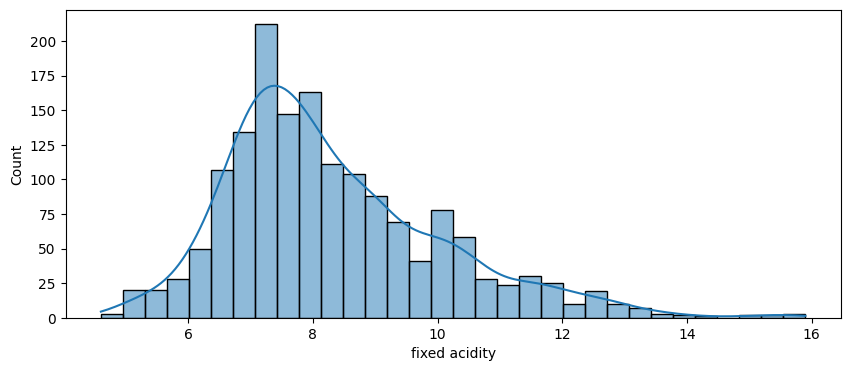

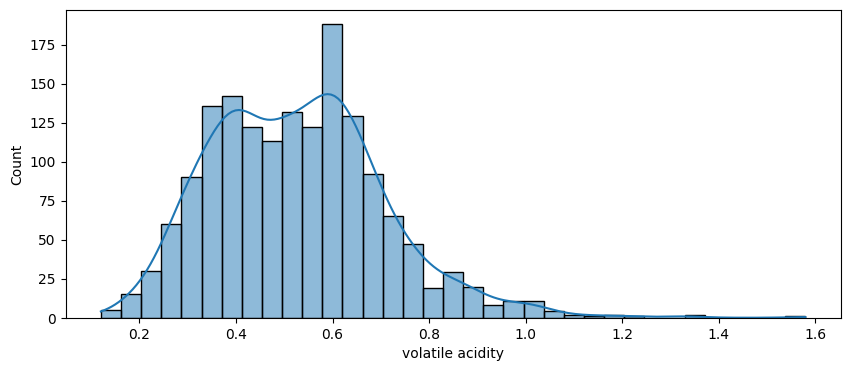

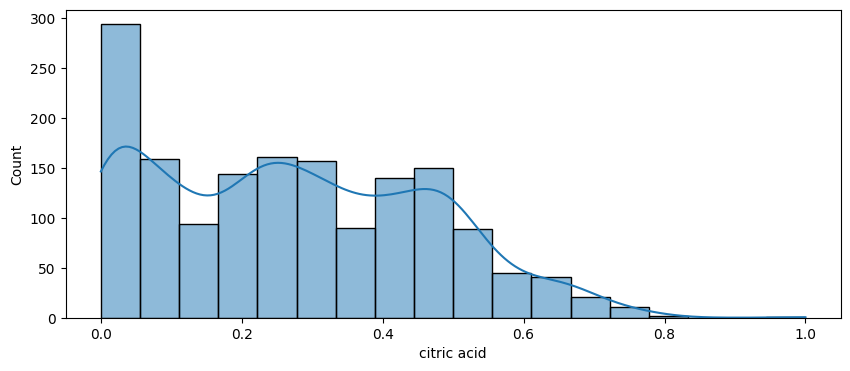

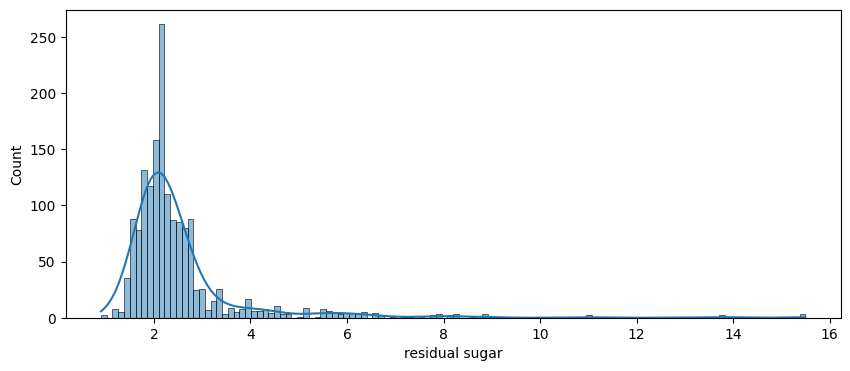

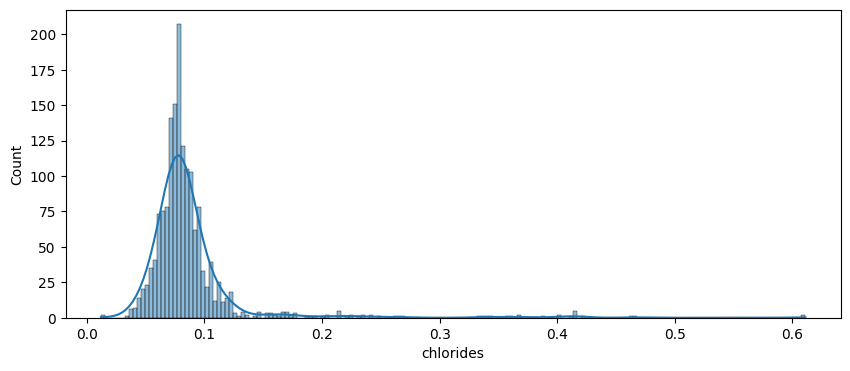

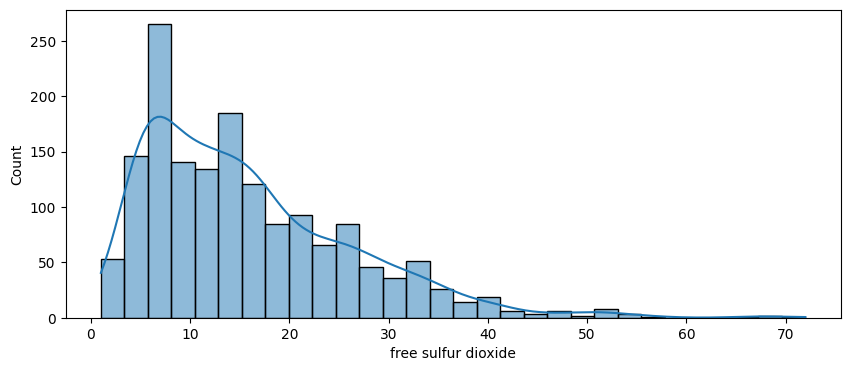

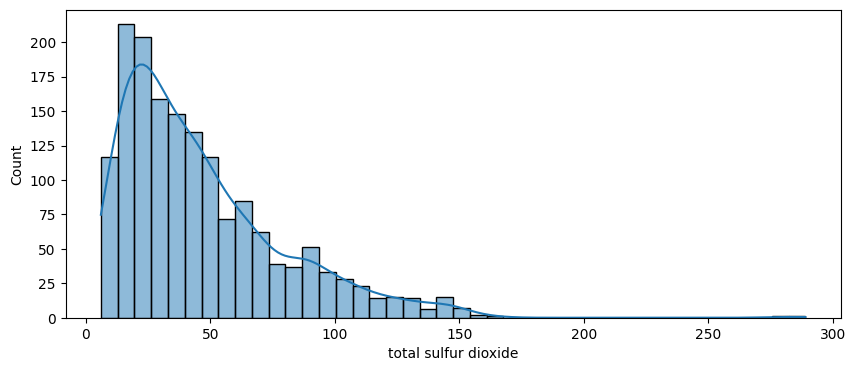

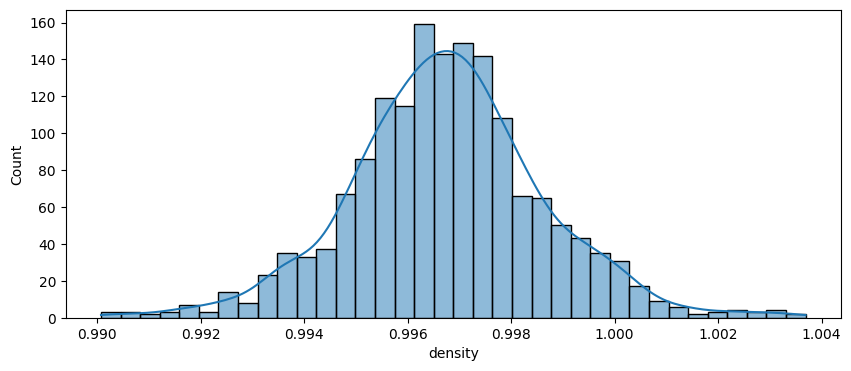

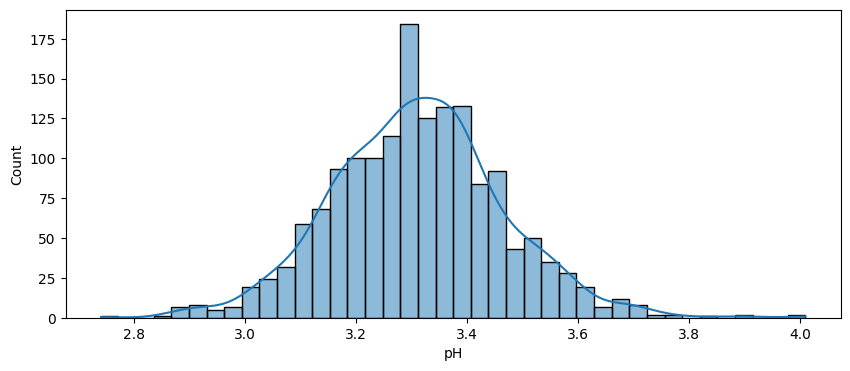

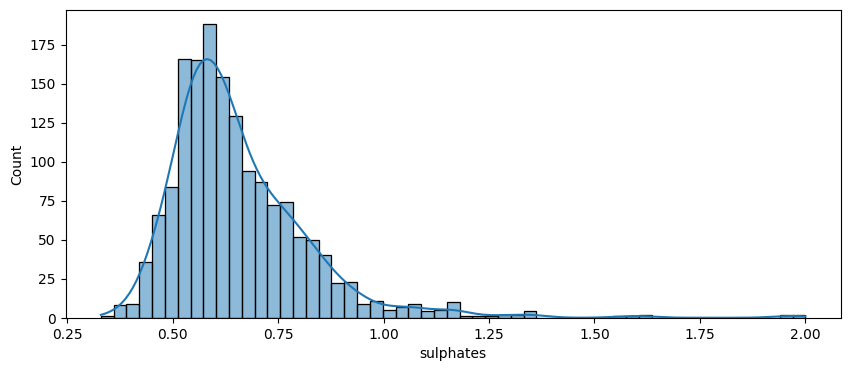

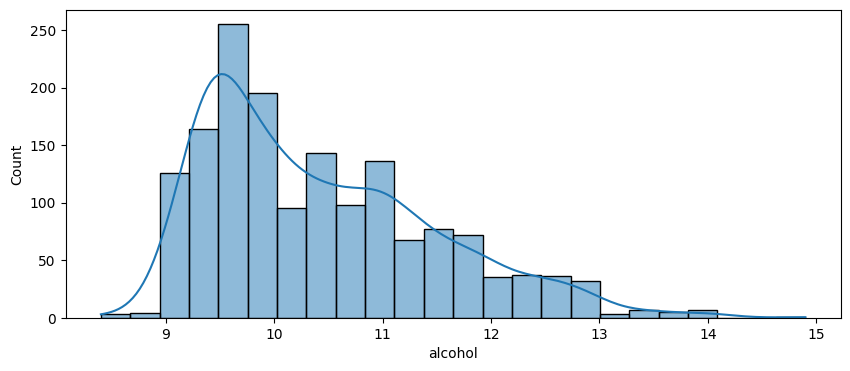

In [741]:
import matplotlib.pyplot as plt

for col in df.columns[:-1]:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], kde=True)

In [742]:
# Add other steps

## Data Manipulation (prep for model)¶

In [743]:
# Split the data
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [744]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [745]:
from sklearn.model_selection import train_test_split
# First split:
# - 70% of the data goes to the training set
# - 30% of the data goes to a temporary set
train_x, ee_x, train_y, ee_y = train_test_split(X, y, test_size=0.3, random_state=42)
train_x.shape

(1119, 11)

In [746]:
# - 15% of the data goes to validation and 15% goes to testing
valid_x, test_x, valid_y, test_y = train_test_split(ee_x, ee_y, test_size=0.5, random_state=42)
valid_x.shape

(240, 11)

In [747]:
train_x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
925,8.6,0.220,0.36,1.9,0.064,53.0,77.0,0.99604,3.47,0.87,11.0
363,12.5,0.460,0.63,2.0,0.071,6.0,15.0,0.99880,2.99,0.87,10.2
906,7.2,0.540,0.27,2.6,0.084,12.0,78.0,0.99640,3.39,0.71,11.0
426,6.4,0.670,0.08,2.1,0.045,19.0,48.0,0.99490,3.49,0.49,11.4
1251,7.5,0.580,0.14,2.2,0.077,27.0,60.0,0.99630,3.28,0.59,9.8
...,...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
860,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5
1459,7.9,0.200,0.35,1.7,0.054,7.0,15.0,0.99458,3.32,0.80,11.9


## Move data to PyTorch ecosystem

In [748]:
import torch

train_x = torch.tensor(train_x.to_numpy())
train_x

tensor([[ 8.6000,  0.2200,  0.3600,  ...,  3.4700,  0.8700, 11.0000],
        [12.5000,  0.4600,  0.6300,  ...,  2.9900,  0.8700, 10.2000],
        [ 7.2000,  0.5400,  0.2700,  ...,  3.3900,  0.7100, 11.0000],
        ...,
        [ 7.2000,  0.6200,  0.0600,  ...,  3.5100,  0.5400,  9.5000],
        [ 7.9000,  0.2000,  0.3500,  ...,  3.3200,  0.8000, 11.9000],
        [ 5.8000,  0.2900,  0.2600,  ...,  3.3900,  0.5400, 13.5000]],
       dtype=torch.float64)

In [749]:
train_x = train_x.float()
train_x

tensor([[ 8.6000,  0.2200,  0.3600,  ...,  3.4700,  0.8700, 11.0000],
        [12.5000,  0.4600,  0.6300,  ...,  2.9900,  0.8700, 10.2000],
        [ 7.2000,  0.5400,  0.2700,  ...,  3.3900,  0.7100, 11.0000],
        ...,
        [ 7.2000,  0.6200,  0.0600,  ...,  3.5100,  0.5400,  9.5000],
        [ 7.9000,  0.2000,  0.3500,  ...,  3.3200,  0.8000, 11.9000],
        [ 5.8000,  0.2900,  0.2600,  ...,  3.3900,  0.5400, 13.5000]])

In [750]:
test_x, valid_x = map(torch.tensor, (test_x.to_numpy(), valid_x.to_numpy()))
test_x = test_x.float()
valid_x = valid_x.float()

In [751]:
valid_x.shape

torch.Size([240, 11])

In [752]:
# Targets must be long in CrossEntropyLoss
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float)
valid_y = torch.tensor(valid_y.to_numpy(), dtype=torch.float)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float)
train_y

tensor([7., 5., 5.,  ..., 5., 7., 6.])

In [753]:
valid_y.shape

torch.Size([240])

In [754]:
train_x.shape

torch.Size([1119, 11])

In [755]:
train_y.shape

torch.Size([1119])

In [756]:
from torch.utils.data import Dataset

class BasicDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y.view(-1,1)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [757]:
train_data = BasicDataset(train_x, train_y)
valid_data = BasicDataset(valid_x, valid_y)
test_data = BasicDataset(test_x, test_y)

In [758]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=11)
valid_loader = DataLoader(dataset=valid_data, batch_size=11)

# Creating a basic MLP

In [759]:
# Define the MLP model
class BasicMLP(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(BasicMLP, self).__init__()
        
        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
    
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [760]:
train_x.shape[1]

11

In [761]:
model = BasicMLP(n_inputs=train_x.shape[1], hidden_size=5, n_outputs=1)

In [762]:
model

BasicMLP(
  (fc1): Linear(in_features=11, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

In [763]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.34)

### Performance
 * In regression, the model predicts a continuous value or a vector of continuous values

In [764]:
import numpy as np
# Training loop

epochs = 100
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()  # Calculate the current losses backward through the MLP
        optimizer.step()  # Apply to the model itself
        batch_losses.append(loss.item())

    # Calculate the training loss per epoch
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    model.eval()
    valid_hyp = model(valid_x)
    valid_loss = criterion(valid_hyp, valid_y)
    valid_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {valid_loss}')

/Users/lemonshark/miniconda/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([240])) that is different to the input size (torch.Size([240, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Train Loss = 7.3142756083432365, Validation Loss = 3.87166428565979
Epoch 1: Train Loss = 2.647066532981162, Validation Loss = 1.7915534973144531
Epoch 2: Train Loss = 1.3869830495586581, Validation Loss = 1.263213038444519
Epoch 3: Train Loss = 1.078627698853904, Validation Loss = 1.1215949058532715
Epoch 4: Train Loss = 0.9857582698265711, Validation Loss = 1.0715769529342651
Epoch 5: Train Loss = 0.9403655694103709, Validation Loss = 1.0426115989685059
Epoch 6: Train Loss = 0.9064748633433791, Validation Loss = 1.0182230472564697
Epoch 7: Train Loss = 0.8766528410362262, Validation Loss = 0.9956954121589661
Epoch 8: Train Loss = 0.8489047645353803, Validation Loss = 0.9757556319236755
Epoch 9: Train Loss = 0.8237889381308182, Validation Loss = 0.9577355980873108
Epoch 10: Train Loss = 0.8008392472185341, Validation Loss = 0.9414821863174438
Epoch 11: Train Loss = 0.7796833839486627, Validation Loss = 0.9269810914993286
Epoch 12: Train Loss = 0.7604966572686738, Validation L

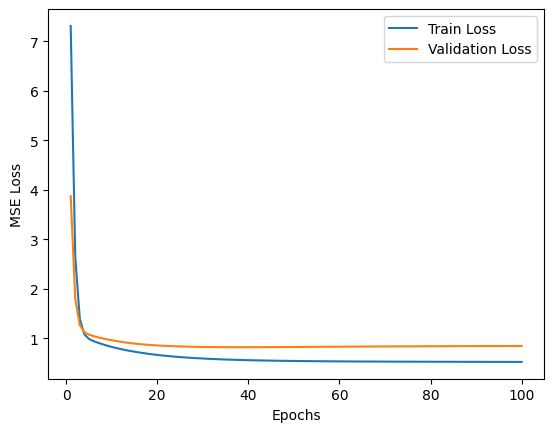

In [765]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curves(epochs, loss_train, loss_valid):
    plt.plot(epochs, loss_train, label='Train Loss')
    plt.plot(epochs, loss_valid, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_loss_curves(np.linspace(1, epochs, epochs).astype(int), train_losses, valid_losses)

In [766]:
test_data = BasicDataset(test_x, test_y)
test_loader = DataLoader(test_data, batch_size=11, shuffle=False)

model.eval()
batch_test_losses = []
for features, targets in test_loader:
    test_hyp = model(features)
    test_loss = criterion(test_hyp, targets)
    batch_test_losses.append(test_loss.item())
baseline_mse = np.mean(batch_test_losses)
print(f'Final Test MSE: {baseline_mse}')

Final Test MSE: 0.5331370844082399


### Making changes to basic MLP
 - Increase the Learning Rate:
 * Change momentum from 0.5 to 0.9 and learning rate from 0.0001 to 0.001, And the performance of my model is increases.

In [767]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [768]:
import numpy as np
# Training loop

epochs = 100
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()  # Calculate the current losses backward through the MLP
        optimizer.step()  # Apply to the model itself
        batch_losses.append(loss.item())

    # Calculate the training loss per epoch
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    model.eval()
    valid_hyp = model(valid_x)
    valid_loss = criterion(valid_hyp, valid_y)
    valid_losses.append(valid_loss.item())


In [769]:
test_data = BasicDataset(test_x, test_y)
test_loader = DataLoader(test_data, batch_size=11, shuffle=False)

model.eval()
batch_test_losses = []
for features, targets in test_loader:
    test_hyp = model(features)
    test_loss = criterion(test_hyp, targets)
    batch_test_losses.append(test_loss.item())
change1_mse = np.mean(batch_test_losses)
print(f'Final Test MSE: {change1_mse}')

Final Test MSE: 0.671935302967375


In [770]:
class NewBasicMLP(torch.nn.Module):
    def __init__(self, n_inputs, hidden_size, n_outputs):
        super(NewBasicMLP, self).__init__()

        self.inputs = n_inputs
        self.hidden = hidden_size
        self.outputs = n_outputs
        
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.fc3 = torch.nn.Linear(self.hidden, self.outputs)
        self.relu = torch.nn.ReLU()
    
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [771]:
model = NewBasicMLP(n_inputs=train_x.shape[1], hidden_size=5, n_outputs=1)

In [772]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [773]:
import numpy as np
# Training loop

epochs = 100
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()  # Calculate the current losses backward through the MLP
        optimizer.step()  # Apply to the model itself
        batch_losses.append(loss.item())

    # Calculate the training loss per epoch
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    model.eval()
    valid_hyp = model(valid_x)
    valid_loss = criterion(valid_hyp, valid_y)
    valid_losses.append(valid_loss.item())


In [774]:
model.eval()
batch_test_losses = []
for features, targets in test_loader:
    test_hyp = model(features)
    test_loss = criterion(test_hyp, targets)
    batch_test_losses.append(test_loss.item())
improved_mse = np.mean(batch_test_losses)
print(f'Final Test MSE: {improved_mse}')

Final Test MSE: 0.526798849078742


In [775]:
model = NewBasicMLP(n_inputs=train_x.shape[1], hidden_size=5, n_outputs=1)

In [776]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [777]:
import numpy as np
# Training loop

epochs = 100
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    batch_losses = []
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()  # Calculate the current losses backward through the MLP
        optimizer.step()  # Apply to the model itself
        batch_losses.append(loss.item())

    # Calculate the training loss per epoch
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    model.eval()
    valid_hyp = model(valid_x)
    valid_loss = criterion(valid_hyp, valid_y)
    valid_losses.append(valid_loss.item())


In [778]:
model.eval()
batch_test_losses = []
for features, targets in test_loader:
    test_hyp = model(features)
    test_loss = criterion(test_hyp, targets)
    batch_test_losses.append(test_loss.item())
improved_mse = np.mean(batch_test_losses)
print(f'Final Test MSE: {improved_mse}')

Final Test MSE: 0.4441267509352077


In [779]:
improvement_percentage = ((baseline_mse - improved_mse) / baseline_mse) * 100
print(f'Improvement Percentage: {improvement_percentage}%')

Improvement Percentage: 16.695580944595143%


# Optional: Implementing the MLP

In [780]:
# Add steps